In [3]:
'''Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA).

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade.

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel.

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

Os Modelos ARIMA são estudados em detalhes e aplicados em diversos e diferentes casos de uso nos cursos Análise Econométrica em R e Análise Estatística Para Data Science II. O curso de Business Analytics também tem projetos onde aplicamos Modelos ARIMA.

Teremos algumas aulas para estudar Modelos Arima. Mas já vamos começar com nosso primeiro modelo.

Fonte: Data science academy'''

In [35]:
## Load nacessary packages
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore',category=matplotlib.cbook.mplDeprecation)

# import manipulation data libs
import numpy as np
import pandas as pd
from datetime import datetime

# import visualization libs
import matplotlib.pyplot as plt
import matplotlib as m
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# import KPIs libs
import math
from math import sqrt
import sklearn
from sklearn.metrics import mean_squared_error

# import graph beaty formats
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize']=14
m.rcParams['xtick.labelsize']=12
m.rcParams['ytick.labelsize']=12
m.rcParams['text.color']='k'
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10



In [ ]:
'''Definição do Problema de Negócio
A HappyMoonVC é uma Venture Capital (VC).

Venture Capital (VC) é um tipo de fundo de investimento focado em capital de crescimento para empresas de médio porte que já possuem carteira de clientes e receita, mas que ainda precisam dar um salto de crescimento.

VCs investem em empresas iniciantes, Startups e emergentes que foram consideradas com alto potencial de crescimento ou que demonstraram alto crescimento (em termos de número de funcionários, receita anual ou ambos).

A HappyMoonVC está analisando um novo e promissor negócio sugerido por uma Startup, o GoInRail.

O GoInRail é um método de transporte inovador que usa a tecnologia de propulsão a jato para executar um veículo similar a um Drone, mas sobre trilhos (que mantém o Drone carregado com energia elétrica) e transportar pessoas em alta velocidade!

O investimento só fará sentido se o GoInRail conseguir mais de 1 milhão de usuários mensais nos próximos 18 meses.

Nosso trabalho é analisar dados de séries temporais com a demanda de transporte em uma determinada região e prever a demanda pelo GoInRail, que ajude a HappyMoonVC a tomar sua decisão de investimento.'''

In [36]:
# data
# we will use simulate data to show transportation customer demand

data_train = pd.read_csv("https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset4.csv")
dados_test = pd.read_csv("https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset5.csv")

In [37]:
# date time columns converter
data_train['Datetime'] = pd.to_datetime(data_train.Datetime, format = '%d-%m-%Y %H:%M')
dados_test['Datetime'] = pd.to_datetime(dados_test.Datetime, format= '%d-%m-%Y %H:%M')

In [38]:
for i in (data_train, dados_test):
    i['ano'] = i.Datetime.dt.year
    i['mes'] = i.Datetime.dt.month
    i['dia'] = i.Datetime.dt.day
    i['hora'] = i.Datetime.dt.hour

In [39]:
# week days extraction
data_train['dia_semana'] = data_train['Datetime'].dt.dayofweek
# if the days were 5 or 6 we set satuday and sunday like weekends
# after we create a function to mark the weekends

def converteWeekend(registro):
    if registro.dayofweek == 5 or registro.dayofweek == 6:
        return 1
    else:
        return 0


In [40]:
# Now we apply the function throw the data
data_train['final_semana'] = data_train['Datetime'].apply(converteWeekend)


In [41]:
# look data
data_train.head()


ID            Datetime  Count   ano  mes  dia  hora  dia_semana  \
0   0 2017-08-25 00:00:00      8  2017    8   25     0           4   
1   1 2017-08-25 01:00:00      2  2017    8   25     1           4   
2   2 2017-08-25 02:00:00      6  2017    8   25     2           4   
3   3 2017-08-25 03:00:00      2  2017    8   25     3           4   
4   4 2017-08-25 04:00:00      2  2017    8   25     4           4   

   final_semana  
0             0  
1             0  
2             0  
3             0  
4             0

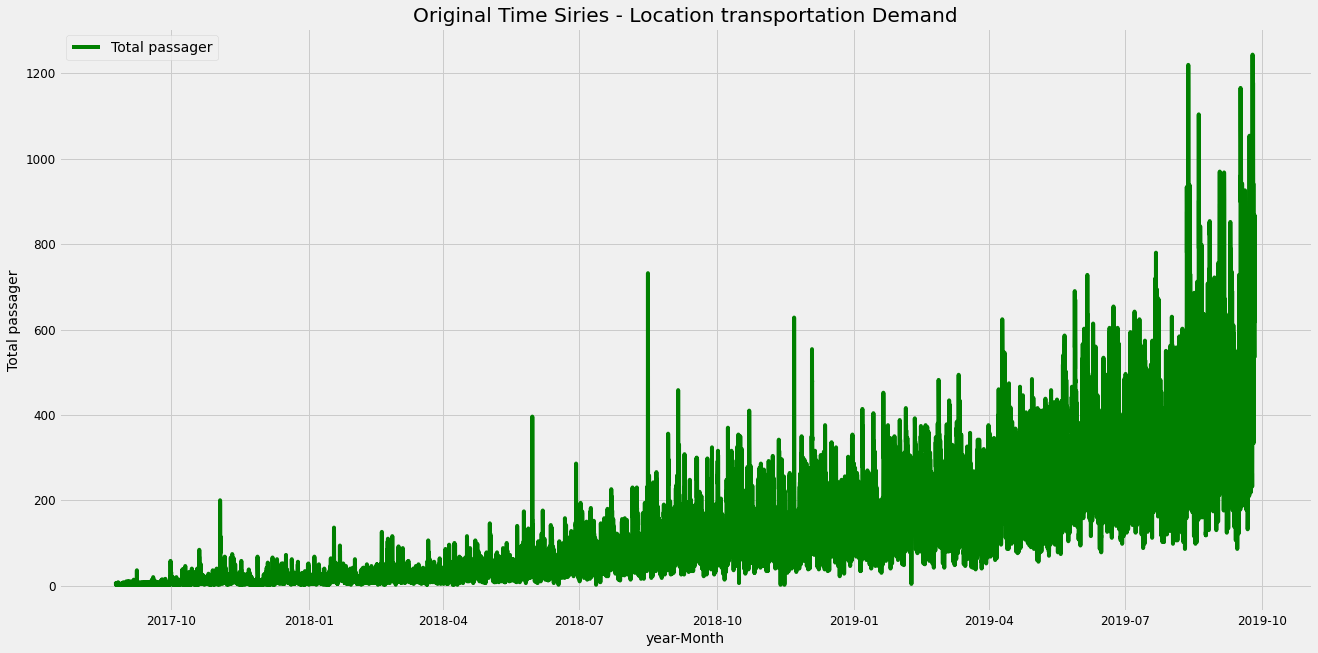

In [42]:
# Data refine to show original series

# index
data_train.index=data_train['Datetime']

# Review ID colmuns because is not interesting for us
features = data_train.drop('ID',1)

# Count variable is our target
target = data_train['Count']

# plot
plt.title("Original Time Siries - Location transportation Demand")
plt.plot(target,label="Total passager",color = 'green')
plt.xlabel('year-Month')
plt.ylabel('Total passager')
plt.legend(loc='best')

In [49]:
# stationarity test
def stationarity_test(serie):

    #moving avarage
    rolmean = serie.rolling(window=12).mean()
    rolstd = serie.rolling(window=12).std()

    # plot stats
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'moving avarage')
    std = plt.plot(rolstd, color= 'black', label = 'STD')
    plt.legend(loc = 'best')
    plt.title('moving avarage stats - mean and STD')
    plt.show()

    # dickey-Fuller test:
    print('\nResult Fuller: \n')

    # test 
    dfteste = adfuller(serie, autolag = 'AIC')

    # exit formatation
    exitdf = pd.Series(dfteste[0:4],index = ['Stats', 'p-value','Lags consider numbers','Observations number'])

    # loop throw items exitdf
    for key, value in dfteste[4].items():
        exitdf['critical value (%s)'%key] = value
    print('\nconclusion')
    print(exitdf)
    if exitdf[1] > 0.05:
        print('\n p value is major then 0.05 then we dont have evidence to descart null hypotheses')
        print('This series probabily is not stationary')
    else: 
        print('\n p value is less then 0.05 then we have evidence to descart null hypotheses')
        print('This series probabily is stationary')



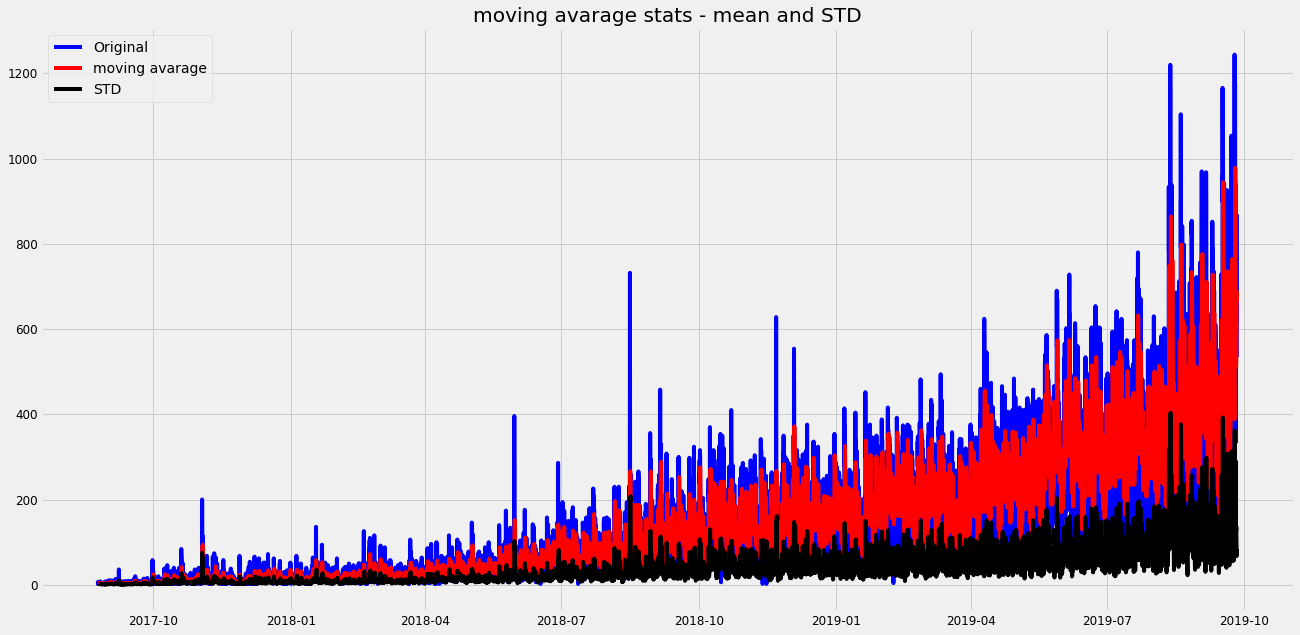


Result Fuller: 


conclusion
Stats                       -4.456561
p-value                      0.000235
Lags consider numbers       45.000000
Observations number      18242.000000
critical value (1%)         -3.430709
critical value (5%)         -2.861698
critical value (10%)        -2.566854
dtype: float64

 p value is less then 0.05 then we have evidence to descart null hypotheses
This series probabily is stationary


In [50]:
stationarity_test(data_train['Count'])

In [51]:
# preprocessing
#  history register separation
df_train = data_train[0:16057]
df_valid = data_train[16058:]

In [53]:
df_train.shape

(16057, 9)

In [54]:
df_valid.shape

(2230, 9)

In [55]:
# Apply log transformation
df_train_log = np.log(df_train['Count'])

In [56]:
# Moving average 
moving_average = df_train_log.rolling(24).mean()

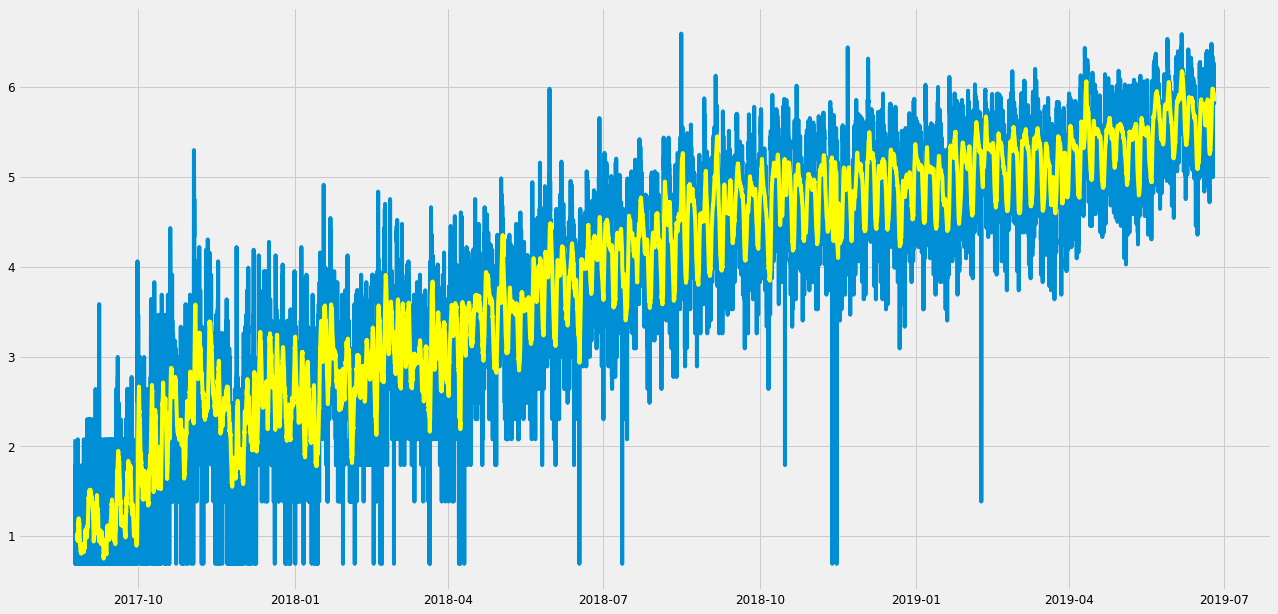

In [57]:
# plot
plt.plot(df_train_log)
plt.plot(moving_average,color = 'yellow')
plt.show()

In [58]:
# differentiation
df_train_moving_average_diff = df_train_log - moving_average
df_train_moving_average_diff.dropna(inplace=True)


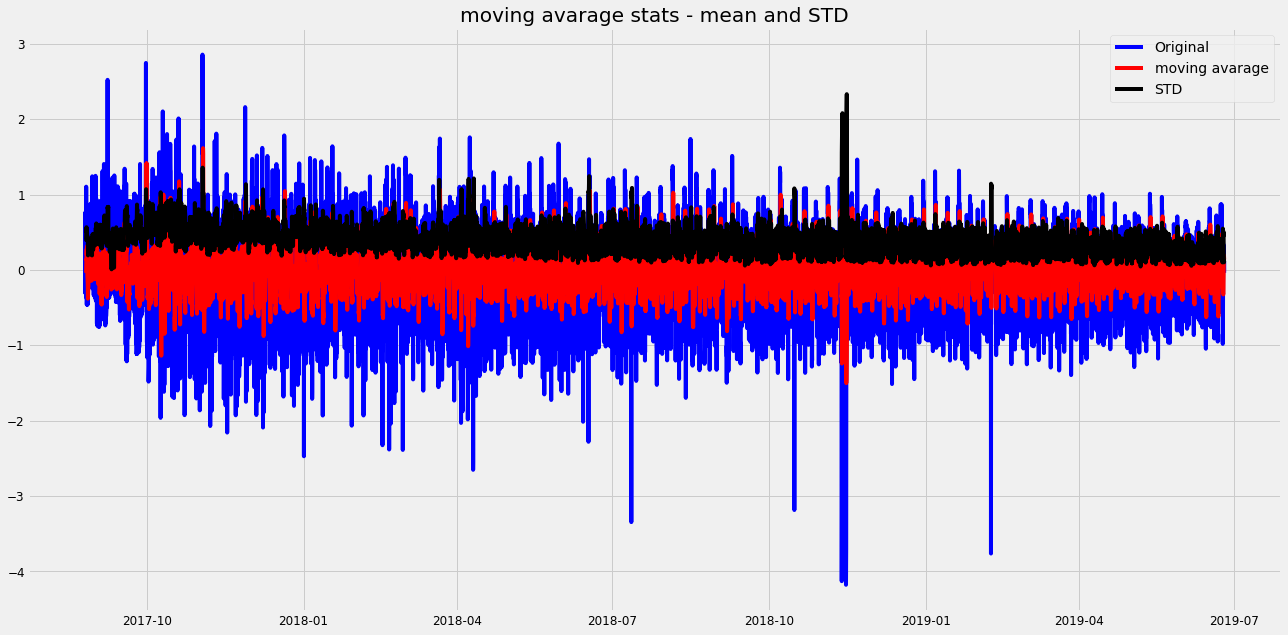


Result Fuller: 


conclusion
Stats                      -22.471885
p-value                      0.000000
Lags consider numbers       43.000000
Observations number      15990.000000
critical value (1%)         -3.430759
critical value (5%)         -2.861721
critical value (10%)        -2.566866
dtype: float64

 p value is less then 0.05 then we have evidence to descart null hypotheses
This series probabily is stationary


In [59]:
# stationarity check
stationarity_test(df_train_moving_average_diff)

In [60]:
# log differentiation
df_train_log_diff = df_train_log - df_train_log.shift(1)

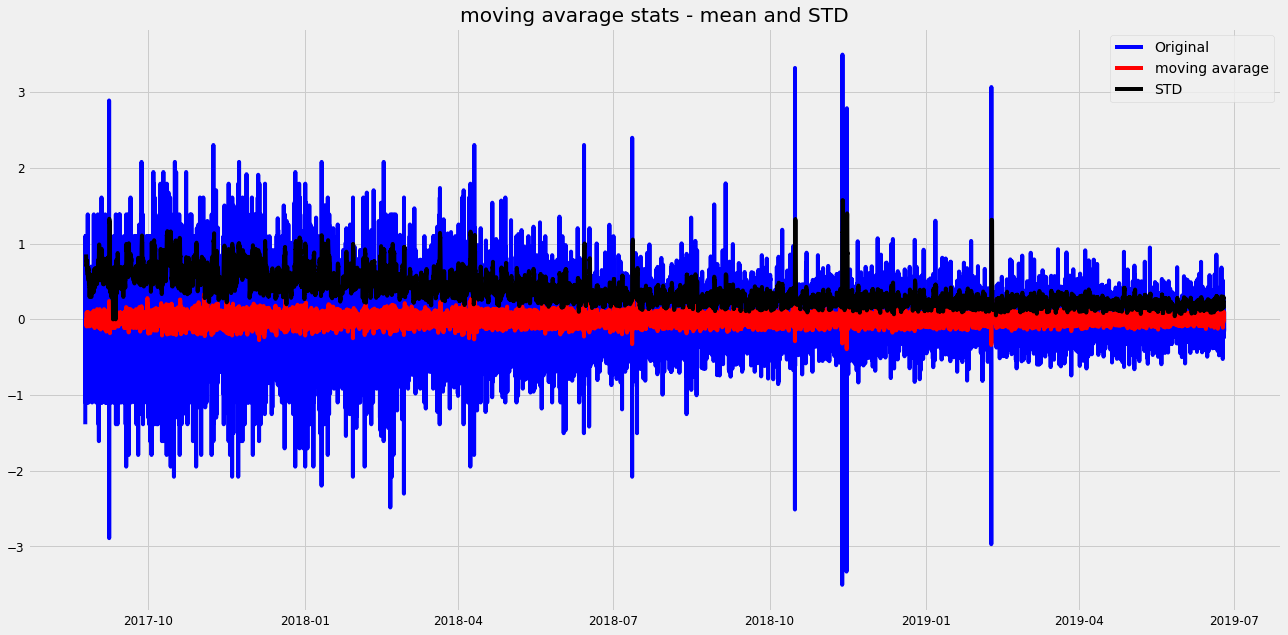


Result Fuller: 


conclusion
Stats                      -28.580228
p-value                      0.000000
Lags consider numbers       43.000000
Observations number      16012.000000
critical value (1%)         -3.430758
critical value (5%)         -2.861721
critical value (10%)        -2.566866
dtype: float64

 p value is less then 0.05 then we have evidence to descart null hypotheses
This series probabily is stationary


In [61]:
stationarity_test(df_train_log_diff.dropna())

In [63]:
# Forcasting predict model
model_AR = ARIMA(df_train_log,order=(2,1,0),freq='H')
model_v1 = model_AR.fit(disp=-1)


In [64]:
# real vs predict data
real_data = df_train_log_diff
predicted = model_v1.fittedvalues

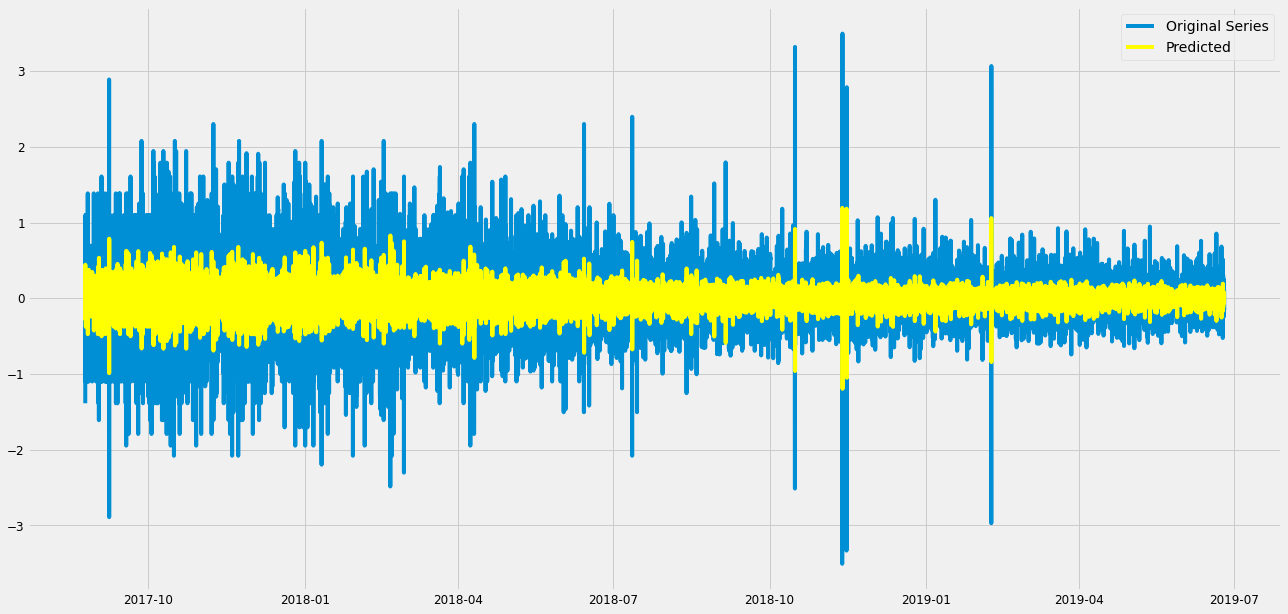

In [65]:
# plot 
plt.plot(real_data, label = 'Original Series')
plt.plot(predicted, color = 'yellow', label = 'Predicted')
plt.legend(loc = 'best')
plt.show()

In [66]:
# Prediction with our model
model_v1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 16277.4337
Dependent Variable: D.Count          Log-Likelihood:      -8119.3   
Date:               2021-07-15 11:18 Scale:               1.0000    
No. Observations:   16056            Method:              css-mle   
Df Model:           3                Sample:              08-25-2017
Df Residuals:       16053                                 06-25-2019
Converged:          1.0000           S.D. of innovations: 0.401     
No. Iterations:     6.0000           HQIC:                16256.862 
AIC:                16246.6983                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            0.0003    0.0022    0.1143  0.9090  -0.0041   0.0047
ar.L1.D.Count   -0.3419    0.0079  -43.4205  0.0000  -0.3573  -0.3265
ar.L2.D.Count   -0.0695    0.0079   -8.8300  0.0000  -0.0850  -0.0541
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -2.4583            -2.8874           3.7921            -0.3623
AR.2           -2.4583             2.8874           3.7921             0.3623
====================================================================

"""

In [82]:
df_valid_log = np.log(df_valid['Count'])

In [81]:
# Forcast 
# 0 param and alfa represent trusted interval in our case is 95%
fc, se ,conf = model_v1.forecast(len(df_valid),alpha = 0.05)

In [83]:
# Predic
fc

array([5.85341811, 5.84846901, 5.8471654 , ..., 6.4184915 , 6.41874795,
       6.41900441])

In [84]:
# Error
se

array([ 0.40121703,  0.48030432,  0.55749778, ..., 13.42012951,
       13.42313971, 13.42614924])

In [85]:
# coefficients
conf

array([[  5.06704719,   6.63978904],
       [  4.90708985,   6.78984818],
       [  4.75448983,   6.93984097],
       ...,
       [-19.884479  ,  32.721462  ],
       [-19.89012244,  32.72761835],
       [-19.89576455,  32.73377337]])

In [86]:
#  We need to make a dataframe for plot creation
fc_series = pd.Series(fc,index= df_valid.index)
inferior_limit = pd.Series(conf[:, 0], index= df_valid.index)
upper_limit = pd.Series(conf[:, 1], index= df_valid.index)

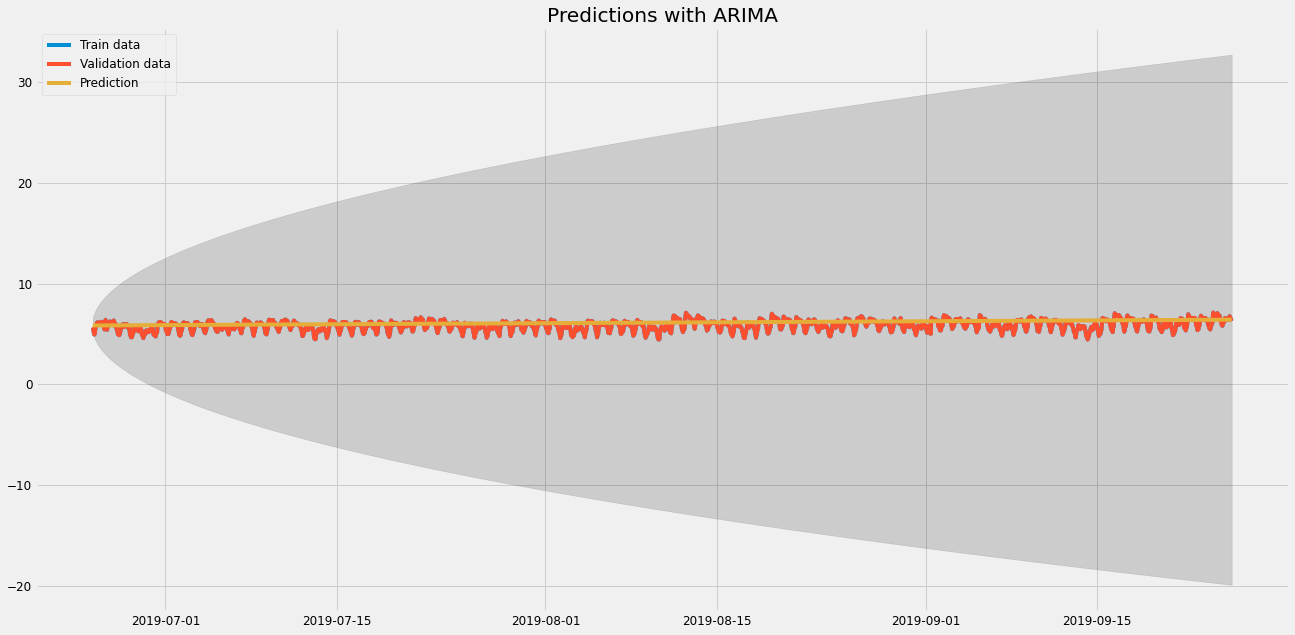

In [87]:
# plot
plt.plot(df_train_log,label='Train data')
plt.plot(df_valid_log, label='Validation data')
plt.plot(fc_series,label='Prediction')
plt.fill_between(inferior_limit.index, inferior_limit,upper_limit,color='k',alpha=.15)
plt.title('Predictions with ARIMA')
plt.legend(loc = 'upper left', fontsize=12)
plt.show()